In [3]:

import json
import os

from pathlib import Path
from typing import Dict, Tuple
from unittest.mock import MagicMock, patch

import numpy as np
import pandas as pd
import pytest

from dl import TEST_DIR
from dl.config.label_map_helper import LabelMapHelper
from dl.dataset import cutnpaste_presampling
from dl.dataset.cutnpaste_preparer import CutnPastePreparer
from dl.dataset.dataframe_schema_constants import (
    CAMERA_LOCATION,
    CAMERA_LOCATION_RIGHT,
    HDR_MODE,
    UNIQUE_ID,
)
from dl.utils.config import (
    DEFAULT_CUTNPASTE_PREPARER_PARAMS,
    DEFAULT_CUTNPASTE_RUNTIME_PARAMS,
    DEFAULT_IMAGE_SIZE,
    HUMAN_LABELSTR_IN_ANNOTATIONS,
    MAX_DEPTH,
)
from dl.utils.cutnpaste import CutnPaste
from dl.utils.helpers import load_master_csv
from tests.example_images.load_image import DatasetWithDatamode

import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
from dl import CVML_DIR

df = load_master_csv(CVML_DIR / '/home/alexli/data/Jupiter_train_v5_11/master_annotations_1k.csv')

In [8]:
from dl.dataset.datamodes.npz.rgbd import RGBDNPZ


rgbdnpz = RGBDNPZ("/home/alexli/data/Jupiter_train_v5_11")

In [57]:
for i in range(100):
    s = np.sum(rgbdnpz.get_artifacts(df.iloc[i])['label'] == 11)
    if s > 0 and df.iloc[i]['label_map']['11'] == 'Humans':
        print(i, s)

8 19882
15 2258
17 27088
19 555
33 4725
42 20484
48 905
50 2142
58 8535
68 1494
72 1452
74 804
83 3955
86 3793
92 4979
97 3460


In [119]:
base_ind = 2
hum_ind = 50
im_no_hum = rgbdnpz.get_artifacts(df.iloc[base_ind])['image']
im_w_hum =  rgbdnpz.get_artifacts(df.iloc[hum_ind])['image']
mask =(rgbdnpz.get_artifacts(df.iloc[hum_ind])['label'] == 11)[:,:,None]

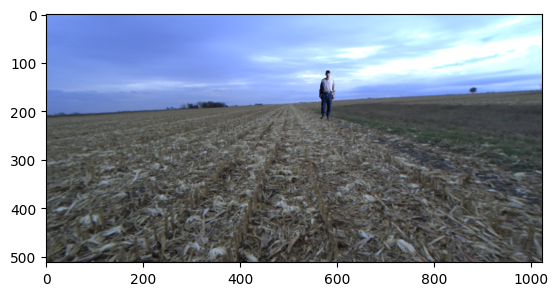

In [120]:
# Vanilla CNP
# plt.imshow(im_w_hum * mask)
# plt.imshow(im_no_hum)
plt.imshow(im_no_hum * (1 - mask) + im_w_hum * mask)

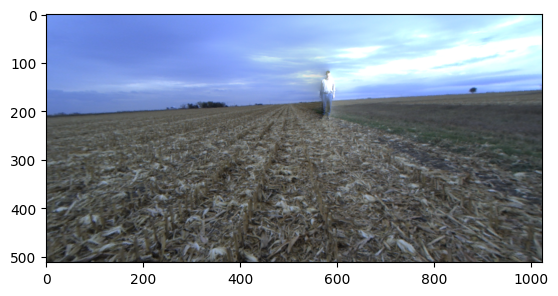

In [121]:
from pietorch import blend_dst_numpy
import torch
target : torch.Tensor = torch.Tensor(im_no_hum) # 3 x N x M image to be blended into
source : torch.Tensor = torch.Tensor(im_w_hum) # 3 x H x W image to be blended
human_mask : torch.Tensor = torch.Tensor(mask)[:,:,0] # H x W mask of which pixels from source to be included
corner : torch.Tensor = torch.IntTensor([0,0]) # [y, x] coordinate of location in target for source to be blended
# result = blend(target, source, human_mask,corner, True, channels_dim=2)
result = blend_dst_numpy(im_no_hum, im_w_hum, mask[:,:,0],corner.numpy(), False, channels_dim=2)

plt.imshow(result)
